In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Reading</p>

In [3]:
train = pd.read_csv('../dataset/train.csv')
test  = pd.read_csv('../dataset/test.csv')
org   = pd.read_csv("../dataset/jm1.csv")   # Original dataset from where train & test were extracted. The competition allows us to use it.

In [5]:
train = train.drop("id", axis=1)
train = pd.concat([train, org], ignore_index=True)

test.drop("id", axis=1, inplace=True)

In [6]:
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Cleaning</p>

In [7]:
fakers=[col for col in train.columns if (train[col].dtype=="O") & (train[col].nunique()>10)]
fakers

['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']

In [8]:
train["uniq_Op"][train["uniq_Op"]=="?"]

101906    ?
102121    ?
103361    ?
105977    ?
110042    ?
Name: uniq_Op, dtype: object

In [9]:
def question_marks_to_NaN(df):
    for col in df.columns:
        df[col]=np.vectorize(lambda x: np.NaN if x == "?" else x)(df[col])
question_marks_to_NaN(train)
question_marks_to_NaN(test)

In [10]:
train[fakers]=train[fakers].astype("float64")
test[fakers]=test[fakers].astype("float64")
train[fakers]=train[fakers].fillna(train[fakers].mode().iloc[0])
test[fakers]=test[fakers].fillna(test[fakers].mode().iloc[0])

In [11]:
train.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64



*  Looks like we have faker columns which act like an object while they are just numbers, also some of them have missing value but it looks like a question mark, lets convert them to NaN then fill the NaN values with mode of this columns.

In [12]:
train.duplicated().sum()

1973

In [13]:
train = train.drop_duplicates()



*  Let's also drop the duplicated 1973 column in the train set, don't clear the duplicates in the test set, your submission should be the same size of the competition wants.

In [14]:
num_cols=[col for col in train.columns if (train[col].dtype in ["int64","float64"]) & (train[col].nunique()>50)]
num_cols

['loc',
 'v(g)',
 'ev(g)',
 'iv(g)',
 'n',
 'v',
 'l',
 'd',
 'i',
 'e',
 'b',
 't',
 'lOCode',
 'lOComment',
 'lOBlank',
 'uniq_Op',
 'uniq_Opnd',
 'total_Op',
 'total_Opnd',
 'branchCount']

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Target</p>

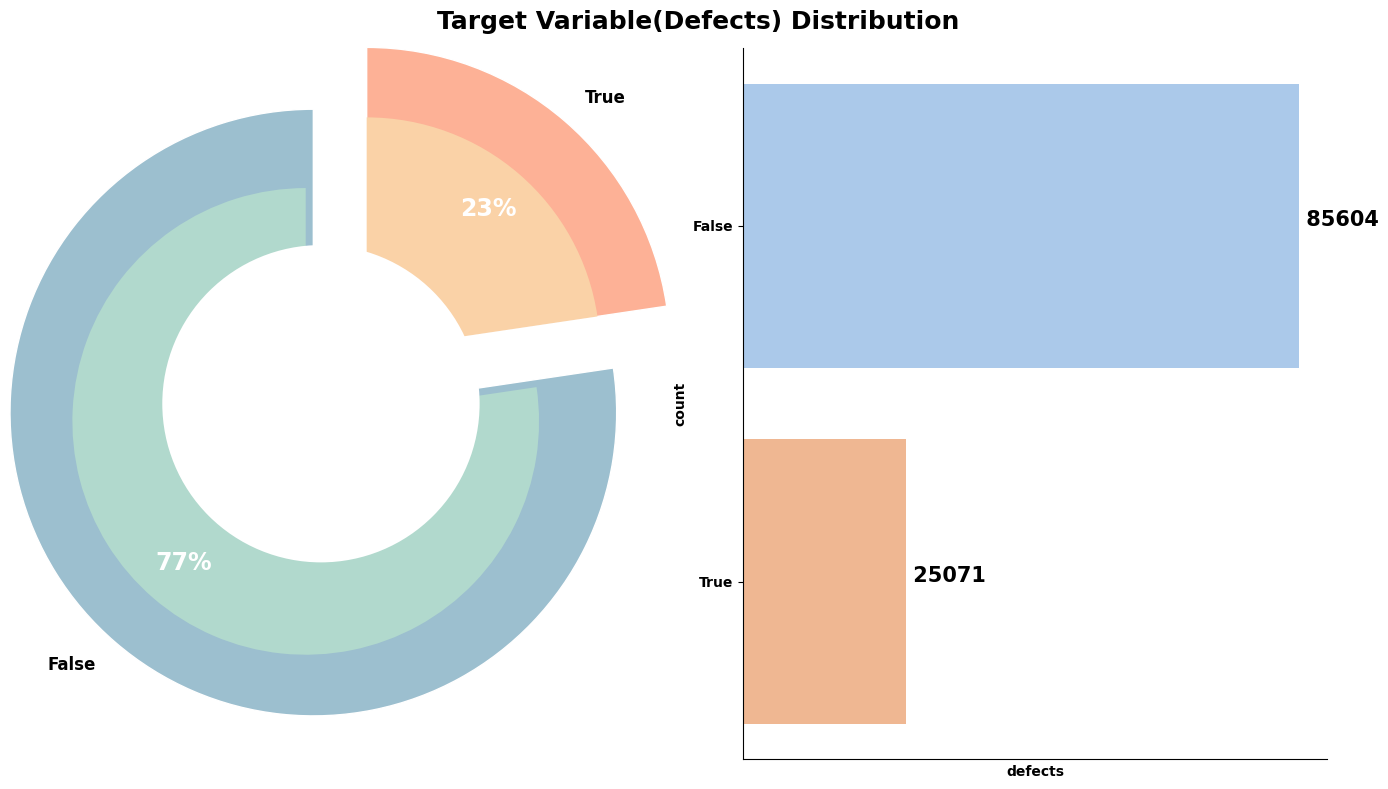

In [15]:
# https://www.kaggle.com/code/kimtaehun/eda-and-baseline-with-multiple-models
def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
    # Set background color
    
    f, ax = plt.subplots(1, 2, figsize=(14, 8))
    plt.subplots_adjust(wspace=0.2)

    s1 = df[col].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#9CBFCF', '#FDB196']
    inner_colors = ['#B1D9CD', '#FAD2A7']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90, frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size': 17, 
        'weight': 'bold', 
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = s1.index.tolist()
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='pastel', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i, " "+str(v), color='black', fontweight='bold', fontsize=15)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_count(train, 'defects', 'Target Variable(Defects) Distribution')



*  It looks like 23% of Target is True and 77% is False, so we have an imbalanced data, we should take it into consideration twice when modeling, do division with "stratify" before modelling, and calculate accuracy with methods that work well with imbalance data.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Categorical</p>



*  so, yes we don't have Categorical data, but some numerics look like categorical, we will check it later if need. (checked, don't need)
    

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Numerical</p>

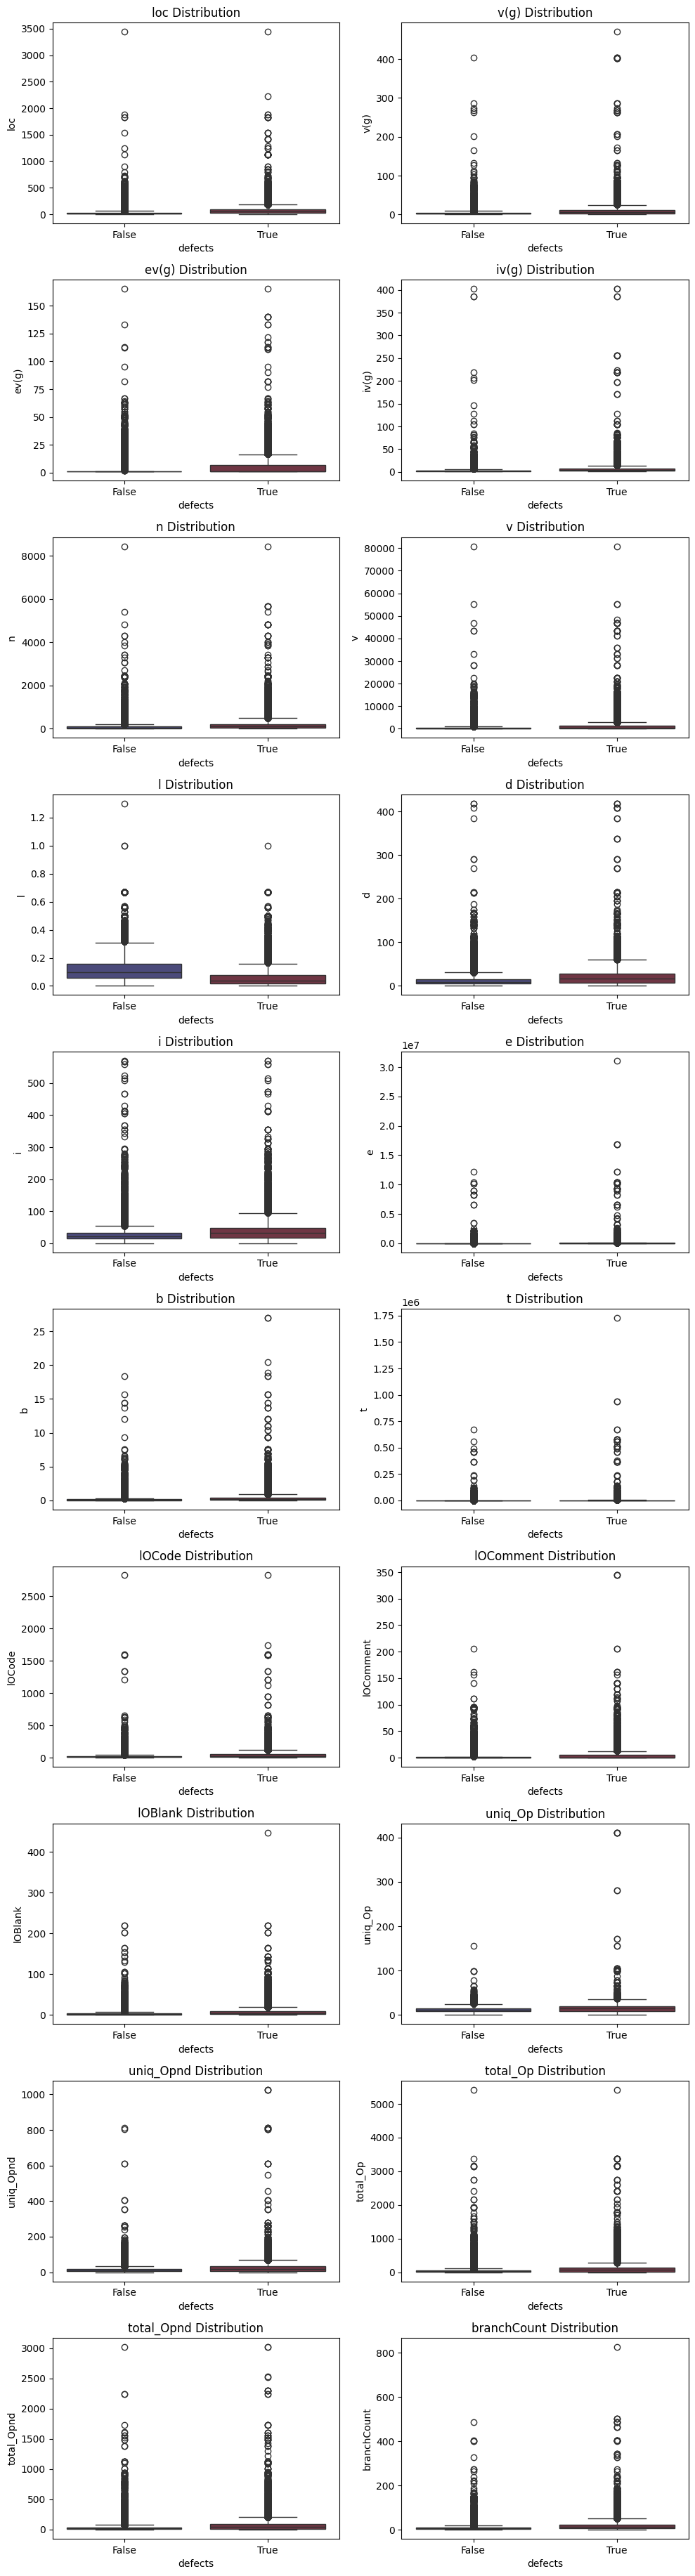

In [18]:
plt.figure(figsize=(10,len(num_cols)*2))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.boxplot(x="defects", y=column, data=train,palette="icefire")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

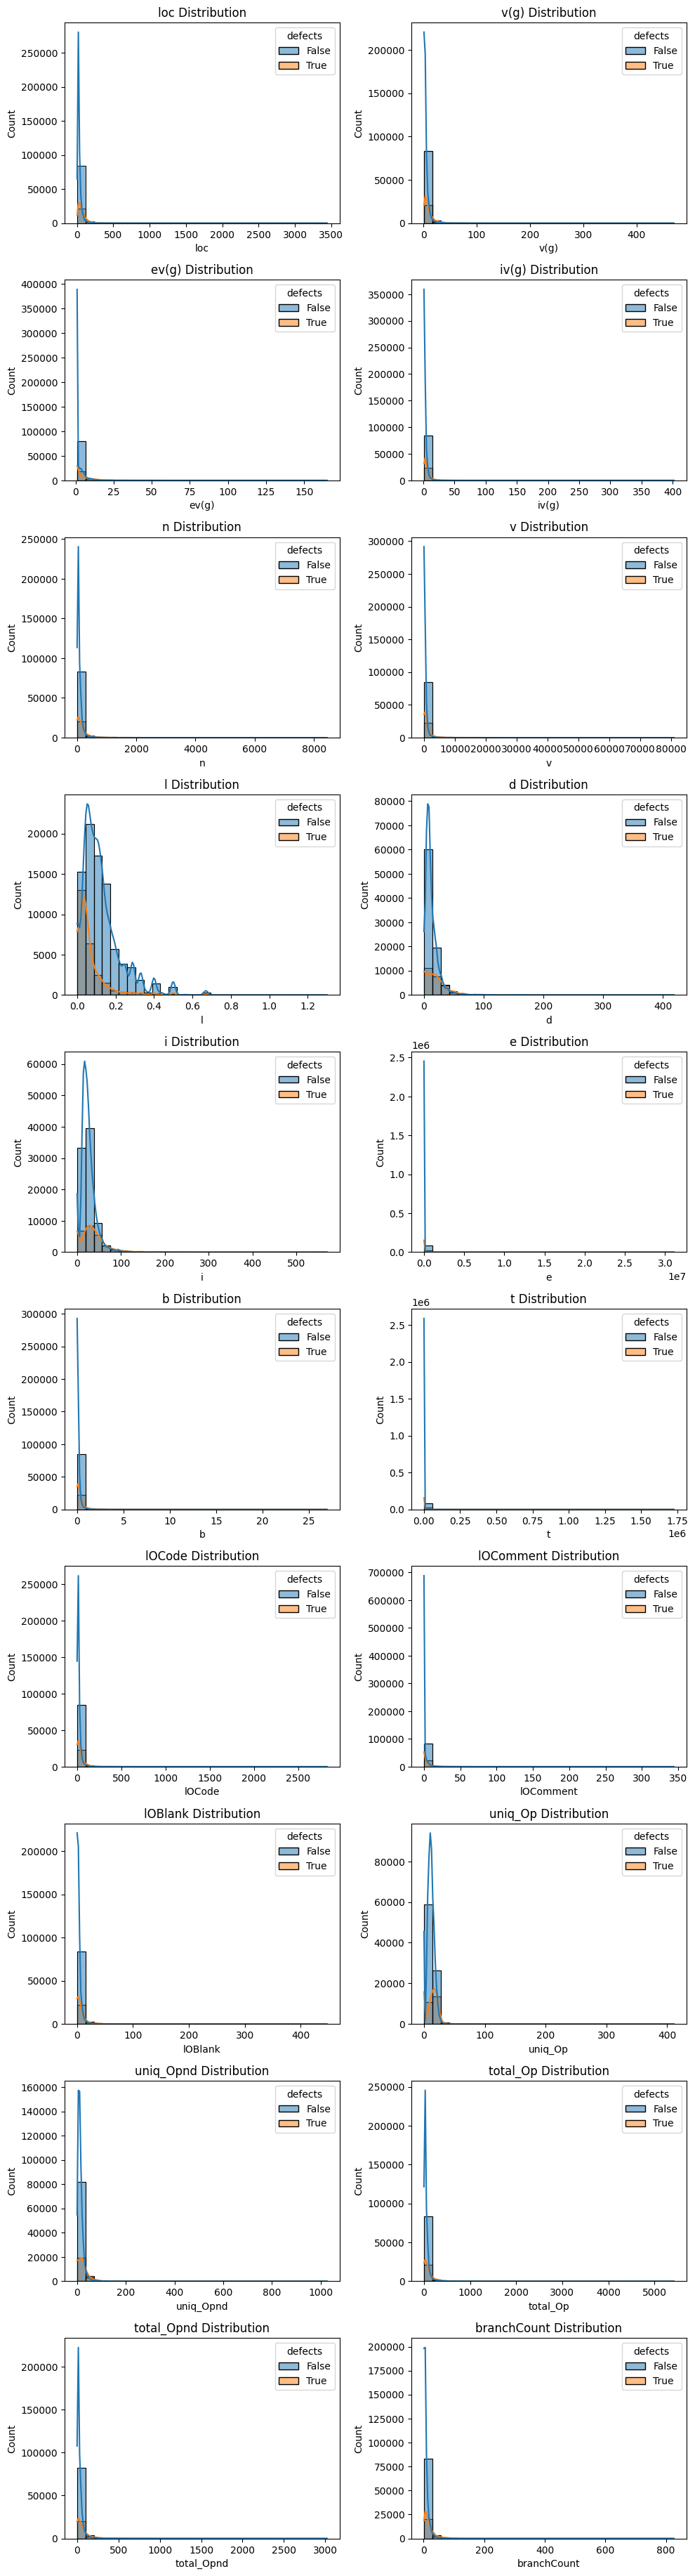

In [22]:
plt.figure(figsize=(10, len(num_cols)*2))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1, 2, idx+1)
    sns.histplot(x=column, hue="defects", data=train, bins=30, kde=True)
    plt.title(f"{column} Distribution")
    plt.tight_layout()

<Axes: >

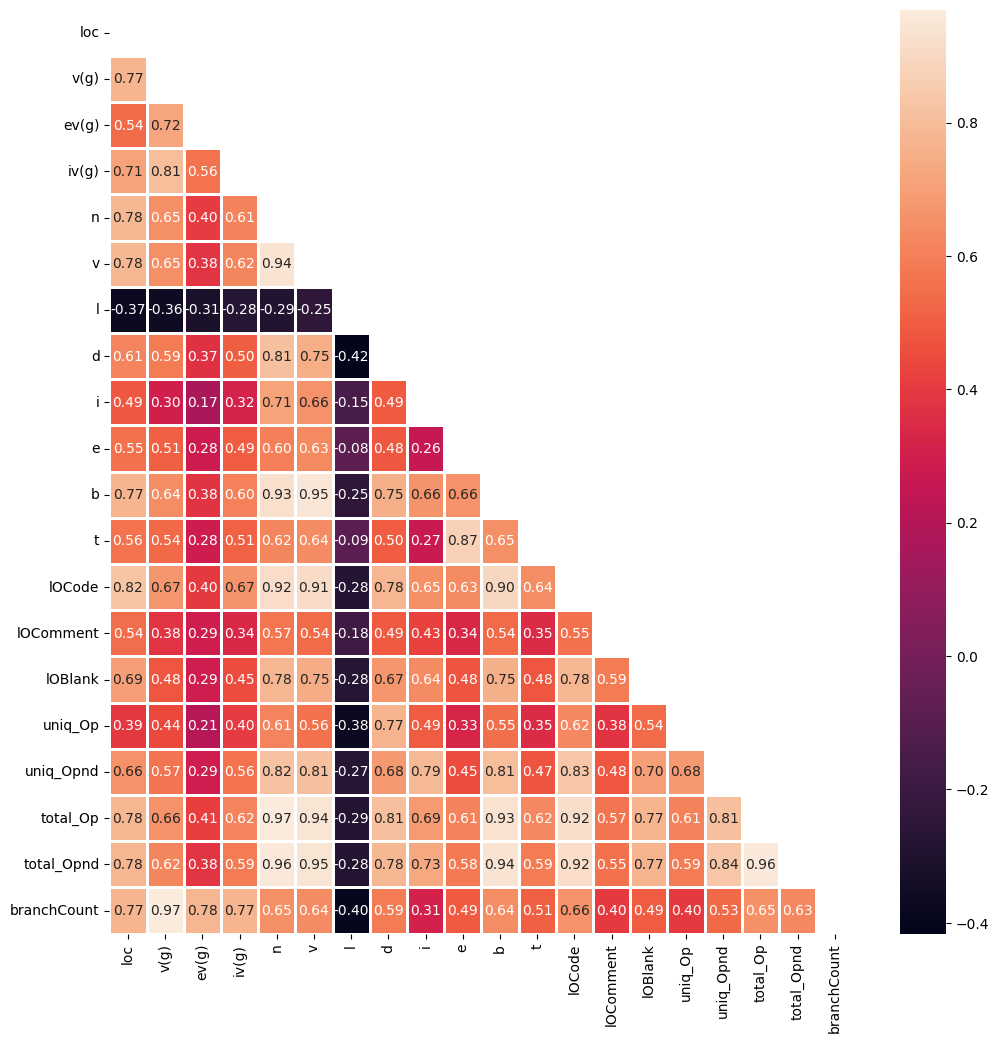

In [26]:
plt.figure(figsize=(12,12))
corr=train[num_cols].corr(numeric_only=True)
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=1, mask=mask)



*  Looks like we have highly correlated features, a lot of outliners and skewed data. Lets take care them one by one, dop one of columns which has high correlation, and max,min limit outliner, then fix the skewness of the data. But before droping correlation over 0.9, we should take care of outliners and skewness.

In [27]:
train["defects"]=train["defects"].map({False: 0,True: 1})



*  Converted defects to numeric  for modeling.

In [28]:
def new_features(df):
    df["complexity"] = df["v(g)"] * df["ev(g)"] * df["iv(g)"]
    df["ComplexEffort"] =  df["complexity"] * df["e"]
    df["LocToLen"] = df["loc"] / (df["l"] + 0.0001)
new_features(train)
new_features(test)


    
*  **complexity**: Calculates Total Complexity of the Code
*  **ComplexityEffort**: Calculates Complexity per effort
*  **LocToLen**: Calculates Code Length / Program Length

In [29]:
def corr_skew_outliner(df, cols):

    #outliner and #skewness part
    for col in cols:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.95)
        df.loc[df[col] < Q1, col] = Q1
        df.loc[df[col] > Q3, col] = Q3
        df[col] = np.sqrt(df[col])
        
    #correlation part
    correlation = df[cols].corr().abs()
    triangle = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
    drop_list = [column for column in triangle.columns if any(triangle[column] > 0.91)]
    df.drop(drop_list, axis=1, inplace=True)
        
    return df

In [30]:
train = corr_skew_outliner(train,train.drop(["defects"],axis=1).columns)
test = corr_skew_outliner(test,test.columns)

In [31]:
new_num_cols=[col for col in train.columns if (train[col].dtype in ["int64","float64"])]

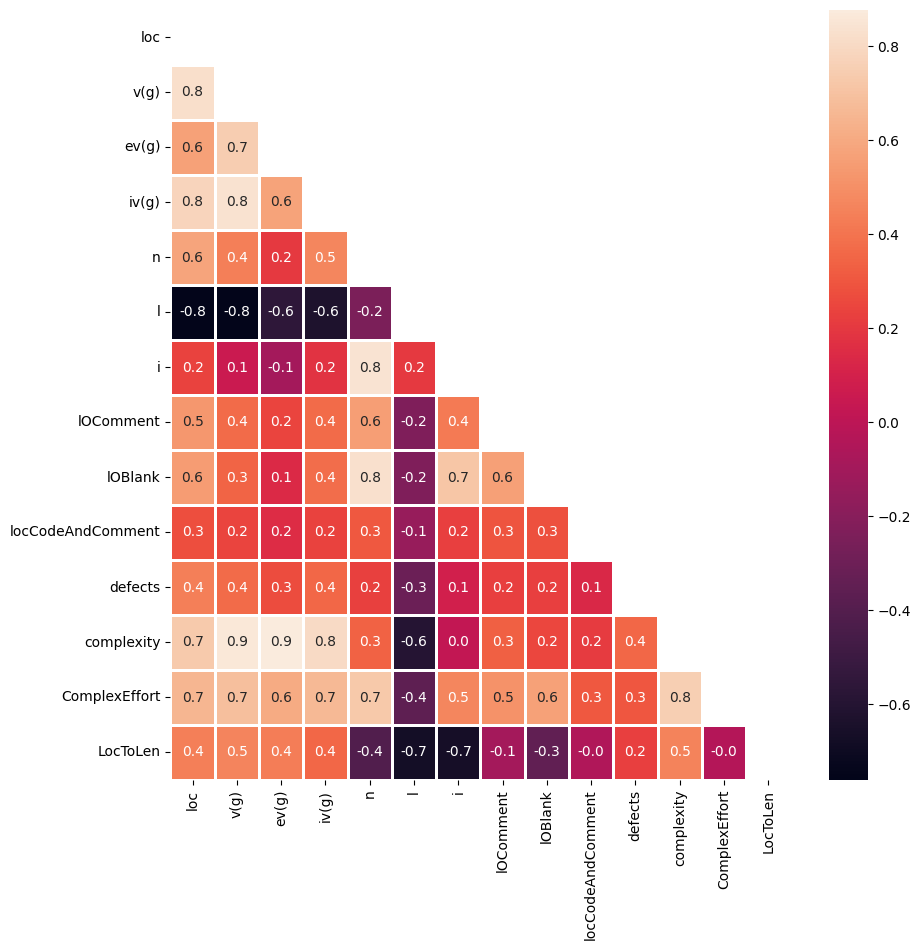

In [32]:
plt.figure(figsize=(10,10))
corr=train.corr(numeric_only=True)
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt=".1f", linewidths=1, mask=mask)
plt.show()



*  Dropped highly correlated features after taking care of outliners and skewness

In [33]:
[print(f" Drop : {x}") for x in (set(num_cols)-set(new_num_cols))];

 Drop : total_Opnd
 Drop : uniq_Op
 Drop : total_Op
 Drop : uniq_Opnd
 Drop : v
 Drop : t
 Drop : b
 Drop : lOCode
 Drop : d
 Drop : e
 Drop : branchCount




*  You can reduce the size of data with PCA here, but I wont on this notebook.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Split</p>

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

X = train.drop("defects", axis=1)
y = train["defects"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=972, stratify=y)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Feature Importance</p>

[LightGBM] [Info] Number of positive: 22564, number of negative: 77043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 99607, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226530 -> initscore=-1.228008
[LightGBM] [Info] Start training from score -1.228008


0.6693092304984893

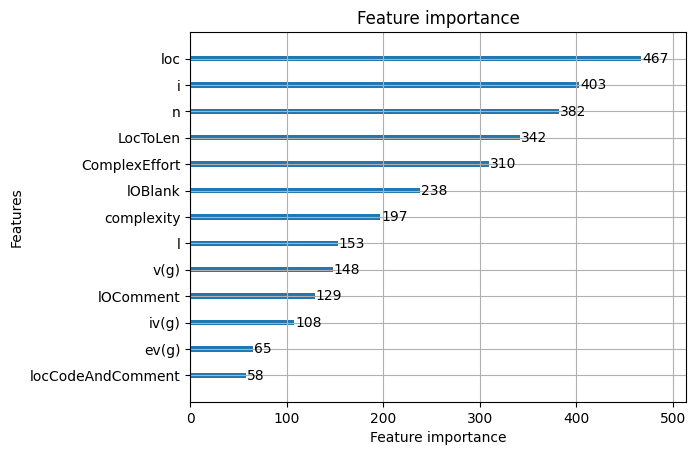

In [35]:
import lightgbm

lgb = lightgbm.LGBMClassifier()
lgb.fit(X_train, y_train)
lightgbm.plot_importance(lgb);
roc_auc_score(y_test,lgb.predict(X_test))

0.6660541466256356

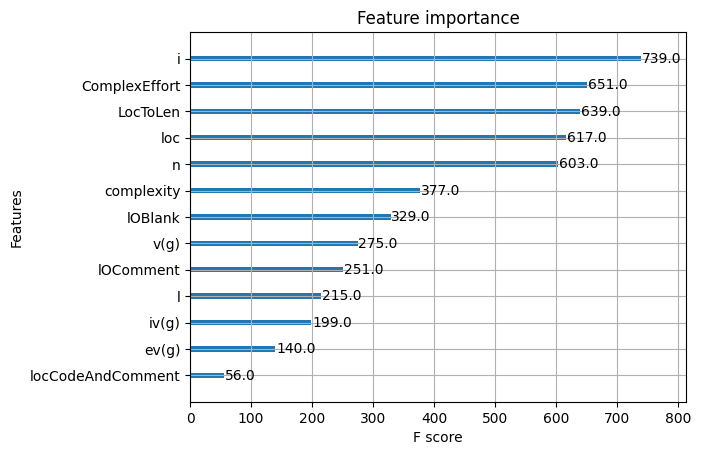

In [36]:
import xgboost
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgboost.plot_importance(xgb);
roc_auc_score(y_test,xgb.predict(X_test))

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Random Forest Classifier</p>

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
y_pred = rf.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8006866642573184


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">XGBoost Classifier</p>

In [38]:
from xgboost import XGBClassifier
import optuna

def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.3, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "seed" : trial.suggest_categorical('seed', [42]),
        'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),
    }

    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    
    return (roc_auc_score(y_test,y_pred))

In [39]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50, show_progress_bar=True)

[I 2023-10-15 18:22:30,381] A new study created in memory with name: no-name-127c0f3b-5d3a-40f3-be34-a37420d7778e
  0%|          | 0/50 [00:00<?, ?it/s]


[W 2023-10-15 18:22:30,966] Trial 0 failed with parameters: {'booster': 'gbtree', 'max_depth': 1, 'learning_rate': 0.011848424431463353, 'n_estimators': 808, 'min_child_weight': 6, 'gamma': 2.4821106015478005e-06, 'subsample': 0.7218817474196005, 'reg_alpha': 0.7002045161117322, 'reg_lambda': 0.7040097839462208, 'seed': 42, 'tree_method': 'gpu_hist', 'objective': 'binary:logistic'} because of the following error: XGBoostError('[18:22:30] C:\\buildkite-agent\\builds\\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\\xgboost\\xgboost-ci-windows\\src\\tree\\updater_gpu_hist.cu:781: Exception in gpu_hist: [18:22:30] C:\\buildkite-agent\\builds\\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\\xgboost\\xgboost-ci-windows\\src\\tree\\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device\n').
Traceback (most recent call last):
  File "d:\Continguts\kaggle-software-defects\venv\Lib\site-packages\optuna\study\_optimize.py"

XGBoostError: [18:22:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [18:22:30] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


In [57]:

print('ROC: ', roc_auc_score(y_test, y_pred))


NameError: name 'y_pred' is not defined

In [47]:
sub["defects"] = voting.predict_proba(test)[:, 1]
sub.to_csv('submission.csv', index=False)
sub

ValueError: No trials are completed yet.